In [71]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
import os
import copy
import collections
import seaborn as sns; sns.set()
import sklearn
from copy import deepcopy
from scipy.sparse import csr_matrix
from soyclustering import SphericalKMeans, proportion_keywords, visualize_pairwise_distance, merge_close_clusters
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import Birch, SpectralClustering, AffinityPropagation, AgglomerativeClustering, MiniBatchKMeans, KMeans, DBSCAN, OPTICS
import matplotlib.colors as colors
import math
import time
import config

In [2]:
# magic line to have in-notebook interactive plots
%matplotlib notebook

In [ ]:
#If you want to use a korean words, unblock it!
# path_gothic = './fonts/NanumBarunGothic.ttf'
# fontprop1 = fm.FontProperties(fname=path_gothic, size=3)

In [3]:
CONFIG = config.Config

In [4]:
# load raw data
target_csv = 'text_doc2vec_seoul_subway'
df_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, target_csv + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print('complete csv shape: ' + str(df_data.shape))
print(df_data.iloc[:100])

complete csv shape: (967598, 300)
                   0         1         2         3         4         5  \
short_code                                                               
--09fdIIig -0.019347  0.005378 -0.105515  0.066705 -0.142596  0.067953   
--4O1jBrrs  0.024496  0.078922 -0.102169 -0.115296 -0.004943  0.131217   
--4fOvyiJZ  0.099579  0.254837 -0.175348 -0.277887 -0.098335  0.188141   
--63y_OQGM  0.118135 -0.125399 -0.154806  0.075649 -0.063159  0.215244   
--6A18OL6v  0.006209  0.031755 -0.028705 -0.046999 -0.007952  0.077744   
--6BXRyHFJ -0.004467  0.014797 -0.088246  0.008649  0.029052  0.085657   
--6JU-AQcI -0.033154  0.058923 -0.001354 -0.196556 -0.127309  0.206515   
--7H4TuQGd  0.030141  0.054315 -0.198527 -0.107117  0.043906  0.335257   
--8MYrPEtW  0.085406  0.087108 -0.080329 -0.242137  0.187053  0.174336   
--AiPTiKsI -0.085414  0.113709 -0.023137  0.011682  0.046448  0.039190   
--B-SiLJXB -0.011080  0.121222  0.068981  0.085588  0.007800  0.139881   
--B-

In [ ]:
print(df_data.describe())

In [ ]:
# data seems to be well normalized to mean or median = 0 and std = 1
plt.figure()
df_data.boxplot()

## Normalization

In [5]:
#df_normalized = df_data.div((np.sqrt(np.sum(np.square(df_data), axis=1))), axis=0)
#df_normalized.to_csv(os.path.join(CONFIG.CSV_PATH, 'normalized_' + target_csv + '.csv'), encoding='utf-8-sig')
df_normalized = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'normalized_' + target_csv + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print('complete csv shape: ' + str(df_normalized.shape))
print(df_normalized.iloc[:100])

complete csv shape: (967598, 300)
                   0         1         2         3         4         5  \
short_code                                                               
--09fdIIig -0.010230  0.002844 -0.055791  0.035270 -0.075398  0.035930   
--4O1jBrrs  0.025865  0.083333 -0.107879 -0.121740 -0.005220  0.138551   
--4fOvyiJZ  0.054307  0.138980 -0.095630 -0.151551 -0.053629  0.102606   
--63y_OQGM  0.044772 -0.047524 -0.058669  0.028670 -0.023936  0.081575   
--6A18OL6v  0.009499  0.048585 -0.043919 -0.071908 -0.012166  0.118948   
--6BXRyHFJ -0.003170  0.010502 -0.062630  0.006138  0.020619  0.060793   
--6JU-AQcI -0.013906  0.024715 -0.000568 -0.082445 -0.053399  0.086622   
--7H4TuQGd  0.012458  0.022450 -0.082059 -0.044276  0.018148  0.138575   
--8MYrPEtW  0.044345  0.045229 -0.041709 -0.125724  0.097123  0.090520   
--AiPTiKsI -0.062756  0.083545 -0.017000  0.008583  0.034127  0.028794   
--B-SiLJXB -0.006805  0.074453  0.042367  0.052567  0.004791  0.085913   
--B-

In [ ]:
print(df_normalized.describe())

In [ ]:
# data seems to be well normalized to mean or median = 0 and std = 1
plt.figure()
df_normalized.boxplot()

## PCA as dimensionality reduction

In [8]:
def scatterplot_pointlabels(df_twocols, markersize=None):
    # basic scatterplot
    fig = plt.figure(figsize=(9.6, 7.2))
    plt.plot(df_twocols.iloc[:, 0], df_twocols.iloc[:, 1], marker='.', linestyle='None', markersize=markersize)

In [ ]:
# PCA
pca = PCA(n_components=100, random_state=42)
df_pca_data = pd.DataFrame(pca.fit_transform(df_data))
df_pca_data.columns = ['PC' + str(i) for i in range(df_pca_data.shape[1])]
df_pca_data.index = df_data.index
print('singular_values_:\n' + str(pca.singular_values_))
print('components_:\n' + str(pca.components_))

# create PCA transformation DF
df_pca_transformation = pd.DataFrame(pca.components_).transpose()
df_pca_transformation.columns = ['PC' + str(i) for i in range(1, pca.n_components_ + 1)]
df_pca_transformation.index = df_data.columns
#print(df_pca_transformation)

In [ ]:
# PCA: plot variance explained
plt.figure()
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle=':')
plt.title('PCA: explained variance')

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle=':')
plt.title('PCA: cumulative explained variance')

In [ ]:
# plot PC dimensions
for dimen1 in range(0, 5):
    for dimen2 in range(dimen1 + 1, 5):
        # subset dataframe to the PC columns we need
        df_tmp = df_pca_data.iloc[:, [dimen1, dimen2]]
        
        # plot without labels
        scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        plt.xlabel(df_tmp.columns[0])
        plt.ylabel(df_tmp.columns[1])

In [ ]:
# PCA
pca_normalized = PCA(n_components=100, random_state=42)
df_pca_normalized = pd.DataFrame(pca_normalized.fit_transform(df_normalized))
df_pca_normalized.columns = ['PC' + str(i) for i in range(df_pca_normalized.shape[1])]
df_pca_normalized.index = df_normalized.index
print('singular_values_:\n' + str(pca_normalized.singular_values_))
print('components_:\n' + str(pca_normalized.components_))

# create PCA transformation DF
df_pca_transformation_normalized = pd.DataFrame(pca_normalized.components_).transpose()
df_pca_transformation_normalized.columns = ['PC' + str(i) for i in range(1, pca_normalized.n_components_ + 1)]
df_pca_transformation_normalized.index = df_normalized.columns
#print(df_pca_transformation)

In [ ]:
# PCA: plot variance explained
plt.figure()
plt.plot(pca_normalized.explained_variance_ratio_, marker='o', linestyle=':')
plt.title('PCA: explained variance')

plt.figure()
plt.plot(np.cumsum(pca_normalized.explained_variance_ratio_), marker='o', linestyle=':')
plt.title('PCA: cumulative explained variance')

In [ ]:
# plot PC dimensions
for dimen1 in range(0, 5):
    for dimen2 in range(dimen1 + 1, 5):
        # subset dataframe to the PC columns we need
        df_tmp = df_pca_normalized.iloc[:, [dimen1, dimen2]]
        
        # plot without labels
        scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        plt.xlabel(df_tmp.columns[0])
        plt.ylabel(df_tmp.columns[1])
        
        # plot with labels
        #scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        #plt.xlabel(df_tmp.columns[0])
        #plt.ylabel(df_tmp.columns[1])

In [6]:
#df_pca_data.to_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_csv + '.csv'), encoding='utf-8-sig')
df_pca_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_csv + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
#df_pca_normalized.to_csv(os.path.join(CONFIG.CSV_PATH, 'pca_normalized_' + target_csv + '.csv'), encoding='utf-8-sig')
df_pca_normalized = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'pca_normalized_' + target_csv + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print(df_pca_data.iloc[:100])

                 PC0       PC1       PC2       PC3       PC4       PC5  \
short_code                                                               
--09fdIIig  0.700282  0.335746 -0.286683  0.127507 -0.430234  0.317758   
--4O1jBrrs -0.075664 -0.088978 -0.050110 -0.186373  0.257487 -0.087244   
--4fOvyiJZ -0.244469 -0.472218  0.187782  0.090324  0.483567  0.199378   
--63y_OQGM  0.482485  0.651434  0.226644  0.087673  0.738554  0.247328   
--6A18OL6v -0.060252  0.061491 -0.222442 -0.029204  0.055198 -0.092664   
--6BXRyHFJ -0.301206  0.563722  0.022558  0.395850  0.162909  0.000778   
--6JU-AQcI -0.058037  0.551777  0.120564 -0.468020  0.457406  0.243933   
--7H4TuQGd  0.381696  0.301483  0.193208  0.163093  0.537901  0.408209   
--8MYrPEtW -0.578851  0.440723 -0.006544  0.037344  0.699289  0.046446   
--AiPTiKsI -0.006854  0.217569  0.080055 -0.250568 -0.222034 -0.186229   
--B-SiLJXB  0.164820  0.324450  0.011087 -0.070957 -0.066513 -0.640921   
--B-T2nJS1  0.286442  0.071808 -0.3984

## t-SNE

In [ ]:
ds_pca_normalized = df_pca_normalized.sample(10000)

In [ ]:
def do_tsne(tsne_object, data_to_pass):
    data_tsne = pd.DataFrame(tsne_object.fit_transform(data_to_pass), index=data_to_pass.index, columns=['tsne1', 'tsne2'])
    return data_tsne

In [ ]:
# on pca
# TODO tune the learning rate and the iterations (rest should be ok i guess)
# lr_list = [100, 500, 1000]
# perp_list = [10, 50, 200]
lr_list = [500]
perp_list = [50]
for lr in lr_list:
    for perp in perp_list:     
        start_time = time.time()
        #tsne_pca = do_tsne(TSNE(n_components=2, perplexity=50, early_exaggeration=12.0, learning_rate=100, n_iter=5000, random_state=42, verbose=1), df_pca_data)
        tsne_pca = do_tsne(MulticoreTSNE(n_components=2, perplexity=perp, learning_rate=lr, n_iter=2000, random_state=42, n_jobs=4, verbose=1), df_pca_normalized)
        print("time elapsed: " + str(time.time()-start_time) + " lr: " + str(lr) + " perp: " + str(perp))
        #scatterplot_pointlabels(tsne_pca, 0.2)
        #plt.title('t-SNE on PCA data lr: ' + str(lr) + ' perp: ' + str(perp) )
        #plt.savefig(os.path.join(CONFIG.SVG_PATH, 'tsne_pca_' + target_csv + '_' + str(lr) + '_' + str(perp) + '.svg'))
        tsne_pca.to_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_pca_' + target_csv + '_' + str(lr) + '_' + str(perp) + '.csv'), encoding='utf-8-sig')

<IPython.core.display.Javascript object>


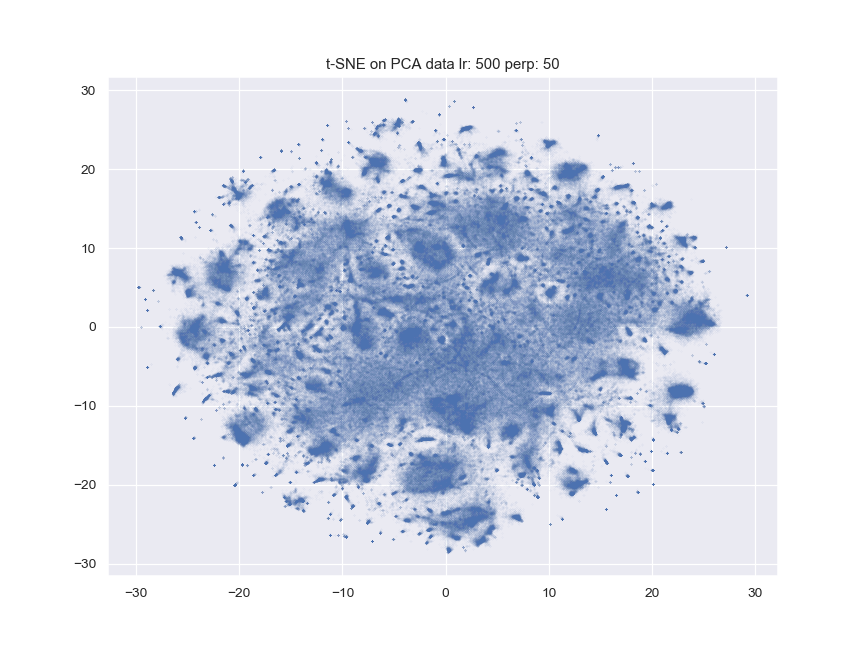

In [9]:
# plot t-SNE with PCA
lr_list = [500]
perp_list = [50]
for lr in lr_list:
    for perp in perp_list:     
        tsne_pca = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_pca_' + target_csv + '_' + str(lr) + '_' + str(perp) + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
        scatterplot_pointlabels(tsne_pca, 0.05)
        plt.title('t-SNE on PCA data lr: ' + str(lr) + ' perp: ' + str(perp) )
        plt.savefig(os.path.join(CONFIG.SVG_PATH, 'tsne_pca_' + target_csv + '_' + str(lr) + '_' + str(perp) + '.svg'))


In [ ]:
# PCA
pca2_normalized = PCA(n_components=2)
pca2_normalized = pd.DataFrame(pca2_normalized.fit_transform(df_pca_normalized))
pca2_normalized.columns = ['PC' + str(i) for i in range(pca2_normalized.shape[1])]
pca2_normalized.index = df_pca_normalized.index

In [ ]:
scatterplot_pointlabels(pca2_normalized, 0.1)
plt.title('PCA visualization')
plt.savefig(os.path.join(CONFIG.SVG_PATH, 'pca2_' + target_csv + '.svg'))


## Clustering

In [32]:
def count_percentage(cluster_labels):
    count = collections.Counter(cluster_labels)
    for k in count:
        print("cluster {} : {:.2%}".format(str(k), count[k]/len(cluster_labels)))

In [75]:
start_time = time.time()
spherical_kmeans = SphericalKMeans(
    n_clusters=24,
    max_iter=20,
    verbose=1,
    init='similar_cut',
    sparsity='minimum_df', 
    minimum_df_factor=0.05,
    random_state=42
)

clustering = spherical_kmeans.fit(csr_matrix(df_normalized.values))
labels = deepcopy(clustering.labels_)
print("time elapsed for clustering: " + str(time.time()-start_time))
start_time = time.time()
print(silhouette_score(df_normalized, labels, sample_size=10000, metric = 'cosine'))
print("time elapsed for silhouette_score: " + str(time.time()-start_time))


initialization_time=0.111701 sec, sparsity=1.0
n_iter=1, changed=871184, inertia=433628.095, iter_time=219.145 sec, sparsity=0.971
n_iter=2, changed=400210, inertia=304671.192, iter_time=216.518 sec, sparsity=0.982
n_iter=3, changed=201296, inertia=295543.689, iter_time=219.468 sec, sparsity=0.981
n_iter=4, changed=128830, inertia=292276.548, iter_time=217.737 sec, sparsity=0.983
n_iter=5, changed=96538, inertia=290469.950, iter_time=222.537 sec, sparsity=0.984
n_iter=6, changed=77502, inertia=289299.207, iter_time=224.170 sec, sparsity=0.983
n_iter=7, changed=64586, inertia=288496.037, iter_time=213.162 sec, sparsity=0.984
n_iter=8, changed=55258, inertia=287908.527, iter_time=216.796 sec, sparsity=0.984
n_iter=9, changed=47696, inertia=287466.565, iter_time=213.960 sec, sparsity=0.984
n_iter=10, changed=42134, inertia=287124.430, iter_time=218.604 sec, sparsity=0.985
n_iter=11, changed=37405, inertia=286847.234, iter_time=214.062 sec, sparsity=0.984
n_iter=12, changed=33573, inertia=

In [83]:
#default_clustering = KMeans(n_clusters = 24, random_state=42).fit(df_normalized)
start_time = time.time()
print(silhouette_score(df_normalized, default_clustering.labels_, sample_size=10000, metric = 'cosine'))
print("time elapsed for silhouette_score: " + str(time.time()-start_time))

0.04861747422696254
time elapsed for silhouette_score: 2.193145513534546


In [77]:
centers = spherical_kmeans.cluster_centers_
count_percentage(labels)

cluster 5 : 4.46%
cluster 16 : 4.09%
cluster 8 : 5.12%
cluster 9 : 3.67%
cluster 14 : 4.46%
cluster 4 : 5.26%
cluster 3 : 5.76%
cluster 23 : 4.16%
cluster 7 : 4.97%
cluster 10 : 4.40%
cluster 1 : 3.28%
cluster 12 : 6.76%
cluster 11 : 3.48%
cluster 19 : 4.32%
cluster 21 : 3.87%
cluster 18 : 3.23%
cluster 13 : 3.82%
cluster 15 : 4.47%
cluster 6 : 2.95%
cluster 2 : 3.16%
cluster 22 : 5.22%
cluster 0 : 3.12%
cluster 17 : 3.86%
cluster 20 : 2.12%


(24, 300)
[[0.         0.26241157 0.32099862 0.2257507  0.21798484 0.19261628
  0.26607316 0.30081367 0.27275394 0.33043825 0.2978615  0.20317676
  0.27244928 0.25217765 0.19098798 0.18630029 0.22159864 0.18770613
  0.19465863 0.14496501 0.25875391 0.31477757 0.18766968 0.19813332]
 [0.26241157 0.         0.355876   0.26101065 0.26367841 0.25588869
  0.33937114 0.28813675 0.17212705 0.25079304 0.30771833 0.24340199
  0.22199639 0.28459225 0.24621162 0.28537569 0.24218821 0.3119474
  0.23671774 0.21643339 0.35269816 0.17796353 0.18218614 0.2079854 ]
 [0.32099862 0.355876   0.         0.37190428 0.40636376 0.31398334
  0.17235937 0.31157178 0.25306506 0.41691494 0.2437975  0.34219597
  0.40439362 0.4283479  0.27211374 0.30353261 0.23586172 0.2384359
  0.35545193 0.27655173 0.16659184 0.35259206 0.20784459 0.43574736]
 [0.2257507  0.26101065 0.37190428 0.         0.11888053 0.22357365
  0.35266838 0.19658207 0.31934711 0.2668693  0.37898818 0.21288456
  0.21343181 0.25105497 0.179907   0.

<IPython.core.display.Javascript object>


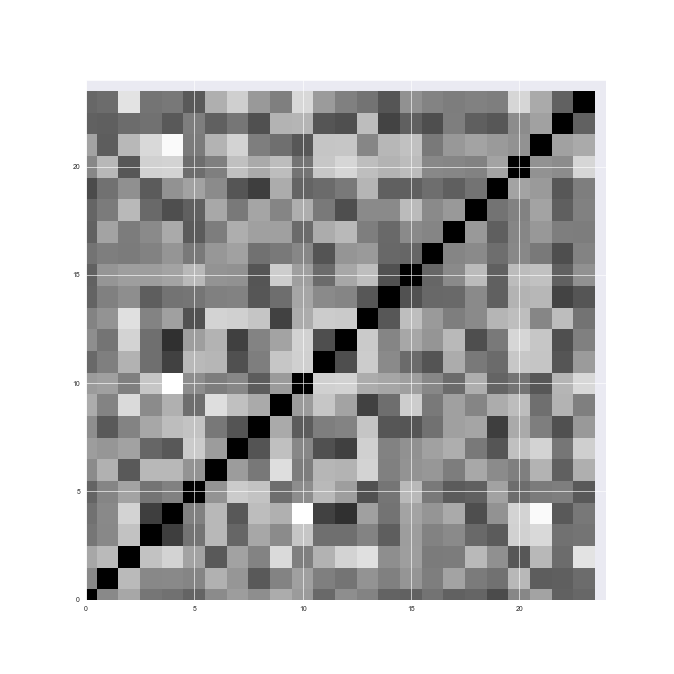

In [82]:
# print pairwise distance between clusters
pdist = pairwise_distances(centers, metric='cosine')
print(centers.shape)
print(pdist)
print(pdist.shape)
fig = visualize_pairwise_distance(centers, max_dist=7e+1, sort=True)

<IPython.core.display.Javascript object>


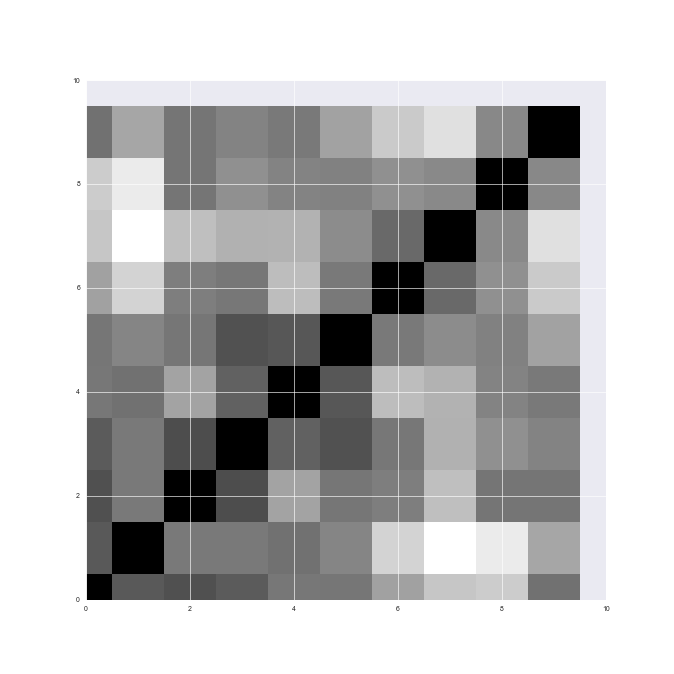

In [92]:
#merge close group
group_centers, groups = merge_close_clusters(centers, labels, max_dist=2e-1)
fig = visualize_pairwise_distance(group_centers, max_dist=2e-1, sort=True)

In [101]:
groups_dict = {}
for group_index, group in enumerate(groups):
    for cluster in group:
        groups_dict[cluster] = group_index
merged_labels = deepcopy(clustering.labels_)
for label_index, label in enumerate(merged_labels):
    merged_labels[label_index] = groups_dict[label]
count_percentage(merged_labels)
print("merged labels are : ", len(groups))
start_time = time.time()
print(silhouette_score(df_normalized, merged_labels, sample_size=10000, metric = 'cosine'))
print("time elapsed for silhouette_score: " + str(time.time()-start_time))

cluster 4 : 16.11%
cluster 3 : 13.02%
cluster 2 : 14.41%
cluster 0 : 23.96%
cluster 1 : 5.76%
cluster 5 : 8.26%
cluster 7 : 3.28%
cluster 8 : 6.11%
cluster 6 : 6.98%
cluster 9 : 2.12%
merged labels are :  10
0.026821930711454542
time elapsed for silhouette_score: 2.0754740238189697


In [89]:
def plot_spectral_clustering(dataframe, num_clusters, markersize=None):
    # plot spectrac clustering result
    # without label
    #scatterplot_pointlabels(dataframe[['x', 'y']], markersize)
    # better colors
    plt.figure(figsize=(9.6, 7.2))
    color_dict = {v: k for v, k in enumerate(sns.color_palette("Paired", num_clusters))}
    sns_plot = sns.scatterplot(x="x", y="y", hue='cluster_id', palette=color_dict, data=dataframe, marker='.', s=markersize, linewidth=0)
    plt.savefig(os.path.join(CONFIG.SVG_PATH, 'clustering_' + target_csv + '.svg'))

In [94]:
df_cluster = pd.DataFrame(data=merged_labels, index=df_normalized.index, columns=['cluster'])
#df_cluster.to_csv(os.path.join(CONFIG.CSV_PATH, 'clustered_kmeans_' + target_csv + '.csv'), encoding='utf-8-sig')
#df_cluster = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'clustered_kmeans_' + target_csv + '.csv'), index_col=0, header=0, encoding='utf-8-sig')

<IPython.core.display.Javascript object>


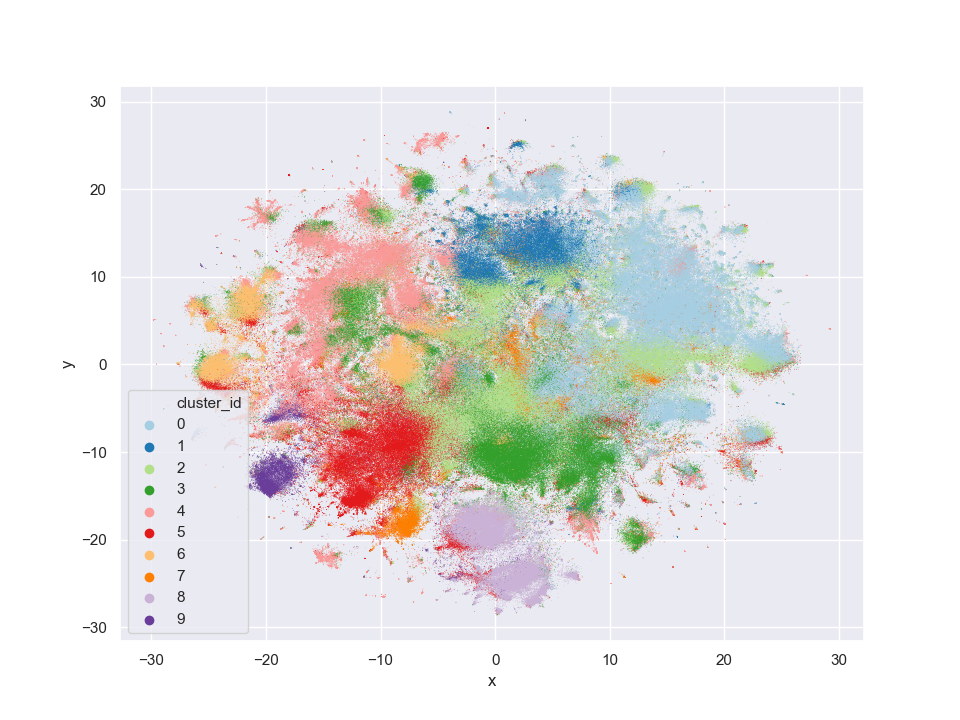

In [99]:
# put clustering info into df
df_tsne_clustered = pd.DataFrame({'x': tsne_pca.tsne1.squeeze(), 
                                      'y': tsne_pca.tsne2.squeeze(), 
                                      'cluster_id': merged_labels})
# debug prints
#print(df_clustered_spectral.dtypes)
plot_spectral_clustering(df_tsne_clustered, len(groups), 1)      